# Importing Dependencies

In [2]:
import os
import numpy as np

import cv2
import matplotlib.pylab as plt

import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Loading Dataset

In [5]:
train_dir = 'imgdata_v2/split_dataset/train/'
val_dir = 'imgdata_v2/split_dataset/val/'
test_dir = 'imgdata_v2/split_dataset/test/'

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Data Augmentation 

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             brightness_range=(0.1, 1.5),
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=16, 
                                                   target_size=(256,256),
                                                   class_mode='binary')

Found 1456 images belonging to 2 classes.


In [93]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                batch_size=16,
                                                target_size=(256, 256),
                                                class_mode='binary')

Found 415 images belonging to 2 classes.


# Importing Evaluation Metrices 

In [94]:
from tensorflow.keras.metrics import Precision, Recall, SpecificityAtSensitivity

pre = Precision()
rec = Recall()
spe = SpecificityAtSensitivity(0.5)

# Creating CNN Model

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', pre, rec, spe])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 127, 127, 16)      0         
                                                                 
 conv2d_31 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 62, 62, 32)      

In [62]:
logdir = 'LogDir'

try:
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)

In [92]:
model_fit = model.fit(train_generator, 
                      epochs=30, 
                      shuffle=True, 
                      validation_data=val_generator, 
                      callbacks=[tfb_callback])

Epoch 1/30
91/91 [==============================] - 7s 64ms/step - loss: 0.7499 - accuracy: 0.5721 - precision_9: 0.5741 - recall_9: 0.6560 - specificity_at_sensitivity_9: 0.6147 - val_loss: 0.6192 - val_accuracy: 0.6747 - val_precision_9: 0.6158 - val_recall_9: 0.9813 - val_specificity_at_sensitivity_9: 0.8955
Epoch 2/30
91/91 [==============================] - 5s 58ms/step - loss: 0.4075 - accuracy: 0.8407 - precision_9: 0.8238 - recall_9: 0.8787 - specificity_at_sensitivity_9: 0.9348 - val_loss: 0.4029 - val_accuracy: 0.8313 - val_precision_9: 0.7647 - val_recall_9: 0.9720 - val_specificity_at_sensitivity_9: 0.9602
Epoch 3/30
91/91 [==============================] - 5s 59ms/step - loss: 0.3431 - accuracy: 0.8709 - precision_9: 0.8452 - recall_9: 0.9173 - specificity_at_sensitivity_9: 0.9419 - val_loss: 0.3651 - val_accuracy: 0.8313 - val_precision_9: 0.7667 - val_recall_9: 0.9673 - val_specificity_at_sensitivity_9: 0.9900
Epoch 4/30
91/91 [==============================] - 5s 60ms/s

# Plotting Model Performance

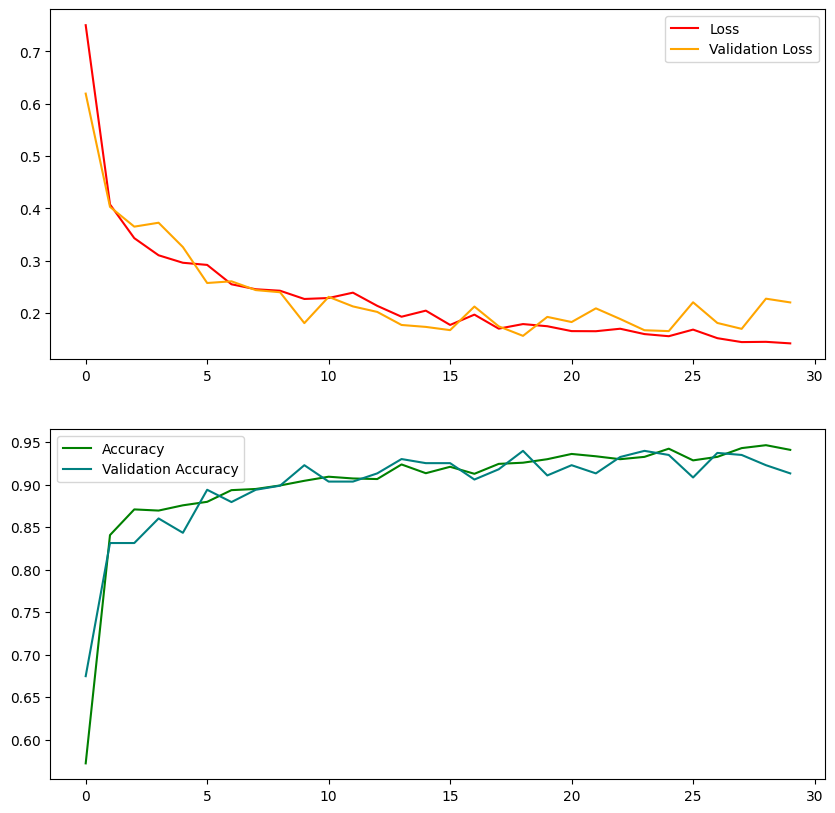

In [95]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))

axs[0].plot(model_fit.history['loss'], 
            color='red', 
            label='Loss')
axs[0].plot(model_fit.history['val_loss'], 
            color='orange', 
            label='Validation Loss')
axs[0].legend(loc='upper right')

axs[1].plot(model_fit.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(model_fit.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')

# Evaluating Model Performance

In [96]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                batch_size=16,
                                                target_size=(256, 256),
                                                class_mode='binary')

Found 210 images belonging to 2 classes.


In [103]:
evaluation = model.evaluate(test_generator, verbose=1)

accuracy = evaluation[1]  # 'accuracy'
precision = evaluation[2]  # Precision
recall = evaluation[3]     # Recall
specificity = evaluation[4]  # SpecificityAtSensitivity(0.5)

f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {round(accuracy, 5)}')
print(f'Precision: {round(precision, 5)}')
print(f'Recall: {round(recall, 5)}')
print(f'Specificity (at sensitivity 0.5): {round(specificity, 5)}')
print(f'F1: {round(f1, 5)}')

14/14 [==============================] - 1s 29ms/step - loss: 0.1398 - accuracy: 0.9524 - precision_9: 0.9224 - recall_9: 0.9907 - specificity_at_sensitivity_9: 1.0000
Accuracy: 0.95238
Precision: 0.92241
Recall: 0.99074
Specificity (at sensitivity 0.5): 1.0
F1: 0.95536
